# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/My Drive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive/Prak_MLMI/model')

Mounted at /content/drive


In [ ]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

import cxr_dataset as CXR

env: CUDA_VISIBLE_DEVICES=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data and Model

### Insert the bottleneck into the model

You can experiment with the location of the bottleneck.

In [ ]:
imagenet_dir = '/home/yang/MLMI_InfoBottleneck/imagenet'
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
PATH_TO_IMAGES = prak_dir + "/BrixIAsmall"
MODEL_PATH = prak_dir + '/model/results/regression_checkpoint_best'
label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# select a model to analyse
saved_model = torch.load(MODEL_PATH, map_location=dev)
model = saved_model['model'].module
del saved_model
model.to(dev).eval()

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
    'val': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
}

# create dataloader
dataset = CXR.CXRDataset(
    path_to_images=PATH_TO_IMAGES,
    fold='train',
    transform=data_transforms['train'],
    fine_tune=True,
    regression=True,
    label_path=label_path)
dataloader = torch.utils.data.DataLoader(
    dataset, 32, shuffle=True, num_workers=4)


In [ ]:
img, label, idx = dataset[7]
print(label)
print(idx)
len(dataset)

5.0
13715630075496956988.jpg


3924

In [ ]:
iba = IBA(model.features.denseblock3)
iba.reset_estimate()

In [ ]:
local_score_dataset = CXR.BrixiaScoreLocal(label_path)
local_score_dataset.getScore(idx)

[0, 0, 1, 1, 1, 2]

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [ ]:
iba.estimate(model, dataloader, device=dev, n_samples=10, progbar=True)

In [ ]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

Neuron at position (12, 3, 4) has mean -0.14 and std 0.07


In [ ]:
iba.estimator.n_samples()

32

## Display Heatmaps for some random samples



In [ ]:
%matplotlib inline

In [ ]:
# generate seed for comparision consistancy
seed = np.random.randint(0, 1000000000)

In [ ]:
def mse_loss(target):
  def model_loss_closure(input):
          loss = torch.nn.MSELoss()
          mse_loss = loss(model(input), torch.tensor(target).to(dev))
          return mse_loss
  return model_loss_closure

In [ ]:
def visualize_heatmap(beta=2, reverse_lambda=False, seed=None, loss_fn=None):
  fig, axes = plt.subplots(4, 5, figsize=(20, 12))
  np.random.seed(seed)
  iba.reverse_lambda = reverse_lambda
  iba.beta = beta
  for ax, sample_idx in zip(axes.flatten(), np.random.choice(2000, 20)):
      img, target, idx = dataset[sample_idx]
      img = img[None].to(dev)
      
      # execute the model on a given sample and return the target NLL
      model_loss_closure = loss_fn(target)
      
      # generate the heatmap
      heatmap = iba.analyze(img, model_loss_closure)
      
      # reverse the data pre-processing for plotting the original image
      np_img = tensor_to_np_img(img[0])
      
      # show the heatmap
      plot_saliency_map(heatmap, np_img,  ax=ax)

      # show label
      scores = local_score_dataset.getScore(idx)
      color_list = ["green", "yellow", "red", "black"]
      for idx, score in enumerate(scores):
        row = (1-idx%3/2)*0.8 + 0.1
        col = idx//3 * 0.8 + 0.1
        plt.text(col, row, score, 
                color="white",
                fontsize = 12,
                bbox=dict(facecolor=color_list[score], alpha=0.7), 
                transform=ax.transAxes)

      # set subplot title
      ax.set_title('{}'.format(idx))
      
  fig.suptitle("model: {}".format(type(model).__name__))
  plt.show()

/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


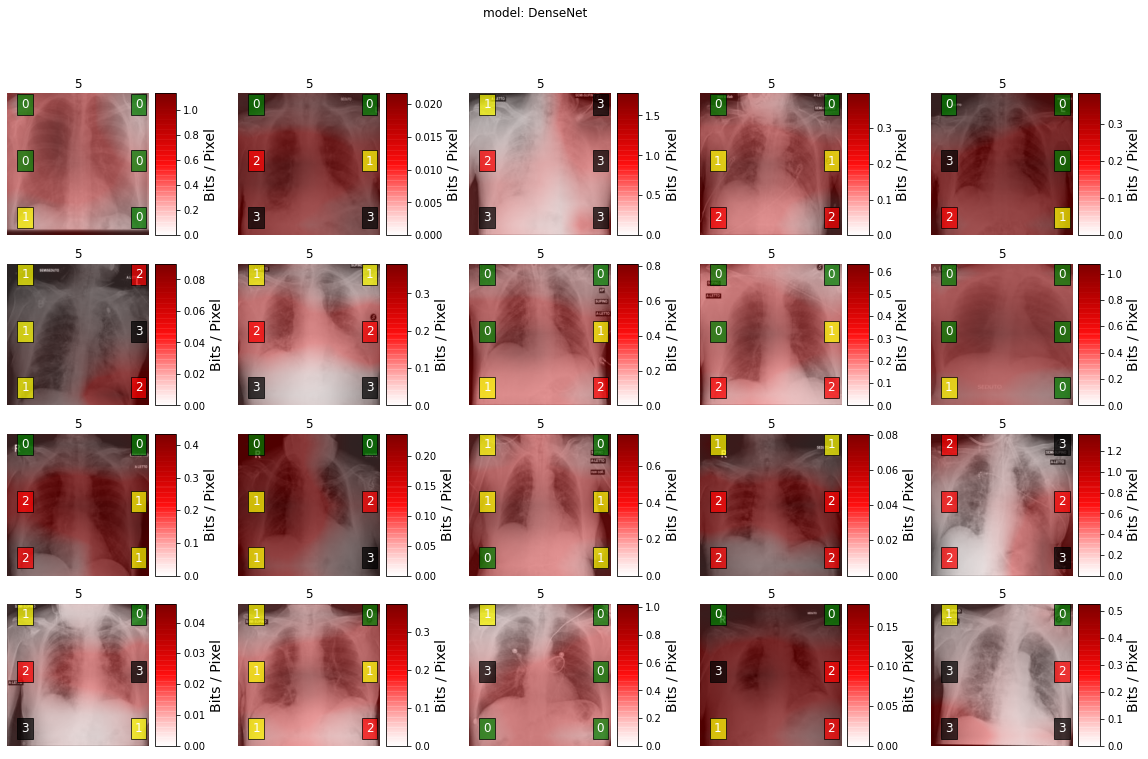

In [ ]:
visualize_heatmap(seed=seed, loss_fn=mse_loss)

Inversed mask

/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


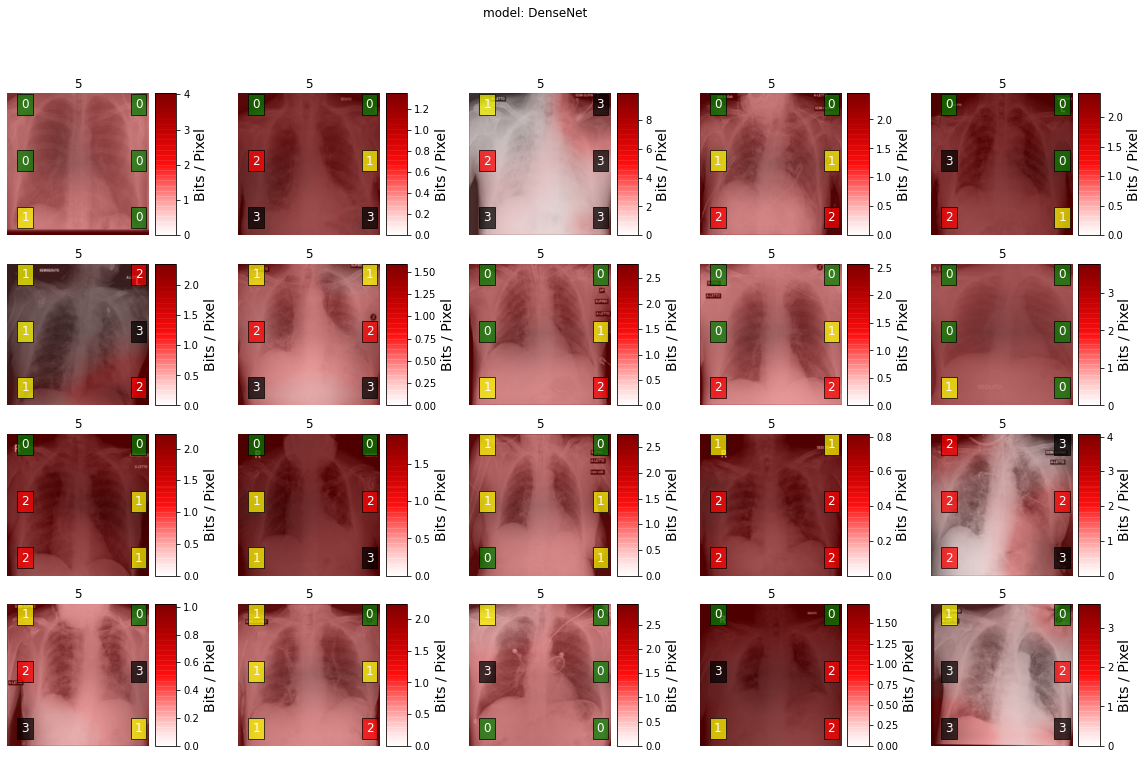

In [ ]:
visualize_heatmap(seed=seed, reverse_lambda=True, loss_fn=mse_loss)

## Experiment with different loss function

### "Maximize the score" loss

In [ ]:
# execute the model on a given sample and return the target NLL
def maximize_score_loss(target):
  def model_loss_closure(input):
    loss = torch.nn.MSELoss()
    mse_loss = -loss(model(input), torch.tensor(0.).to(dev))
    return mse_loss
  return model_loss_closure

/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


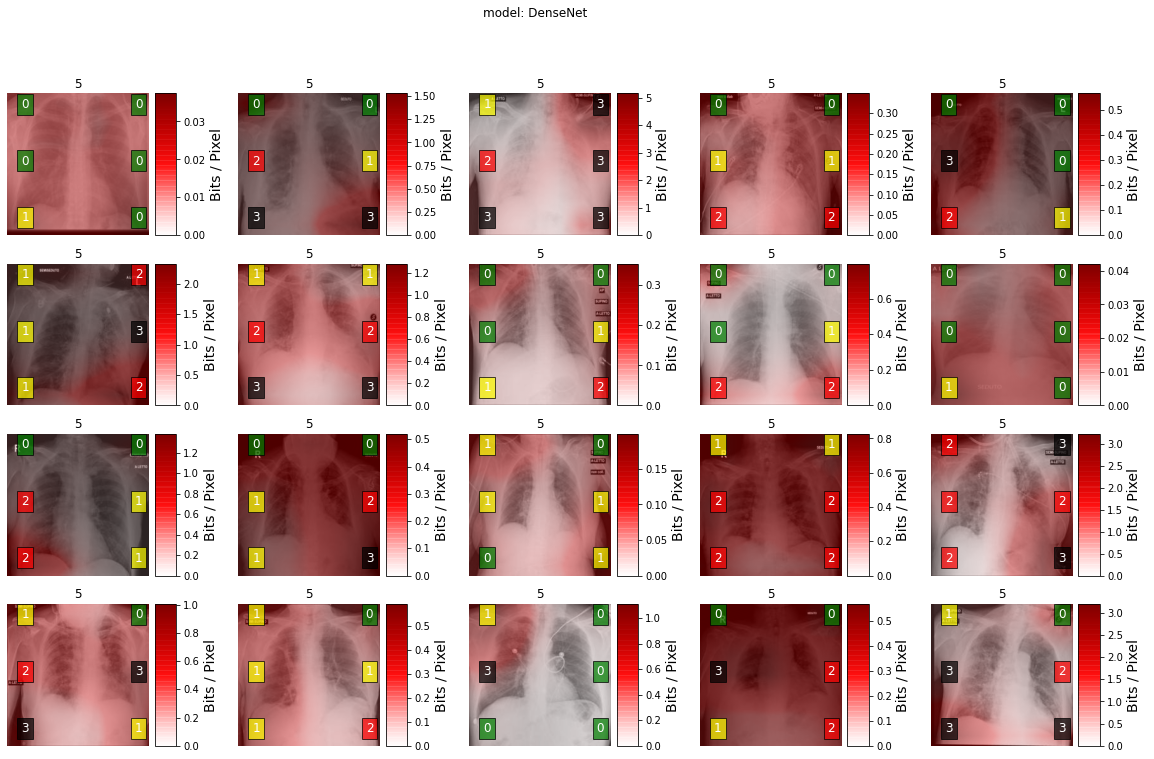

In [ ]:
visualize_heatmap(seed=seed, beta=10, reverse_lambda=False, loss_fn=maximize_score_loss)

/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


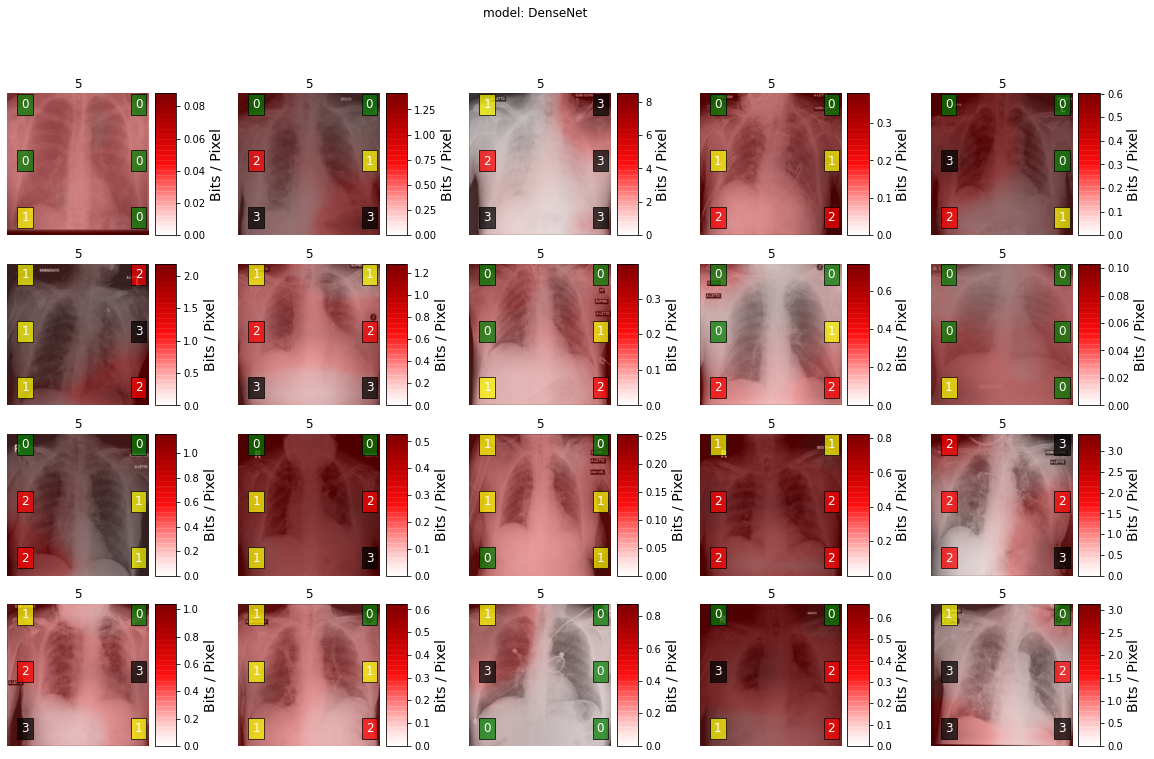

In [ ]:
visualize_heatmap(seed=seed, beta=10, reverse_lambda=True, loss_fn=maximize_score_loss)

### "Deviation" loss

In [ ]:
# execute the model on a given sample and return the target NLL
def deviation_loss(original_model=None):
  def loss_wrapper(target):
    def model_loss_closure(input):
      loss = torch.nn.MSELoss()
      assert original_model is not None, "please give a model!"
      mse_loss = loss(model(input), original_model(input))
      return mse_loss
    return model_loss_closure
  return loss_wrapper

In [ ]:
# load an original model for score generation
saved_model = torch.load(MODEL_PATH, map_location=dev)
original_model = saved_model['model'].module;
del saved_model
original_model.to(dev).eval();

/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "


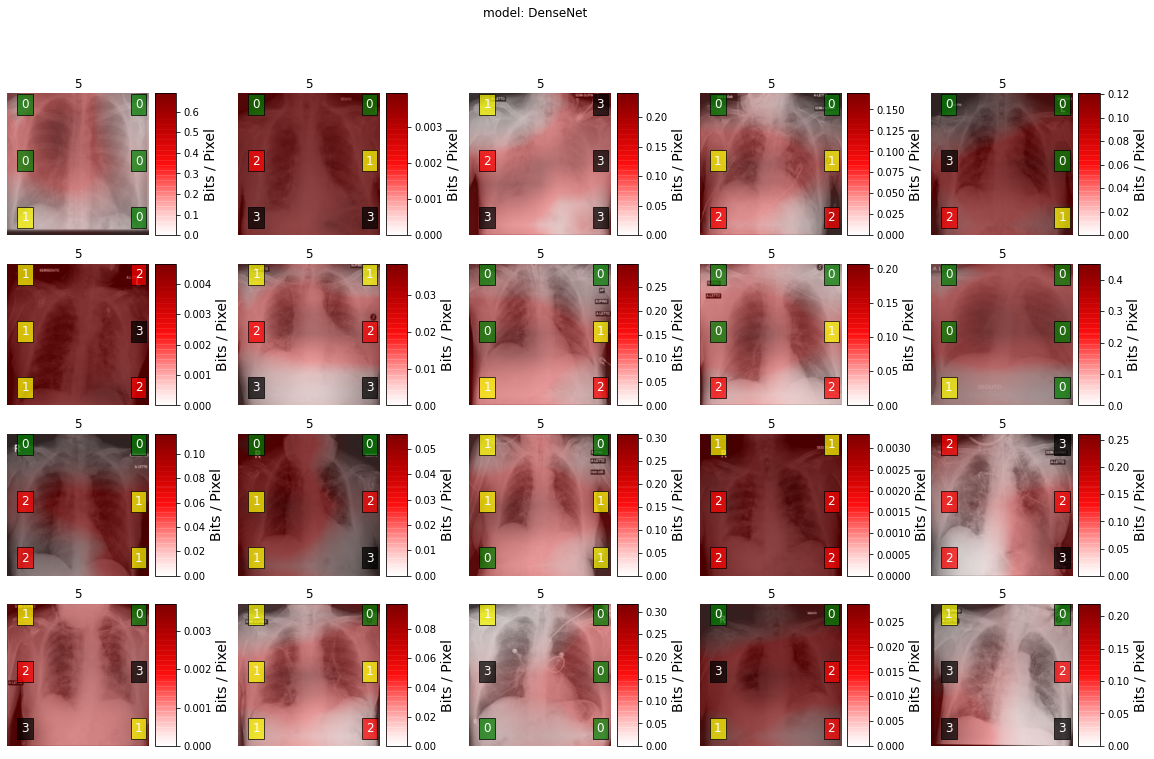

In [ ]:
visualize_heatmap(seed=seed, beta=20, reverse_lambda=False, loss_fn=deviation_loss(original_model=original_model))

/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "


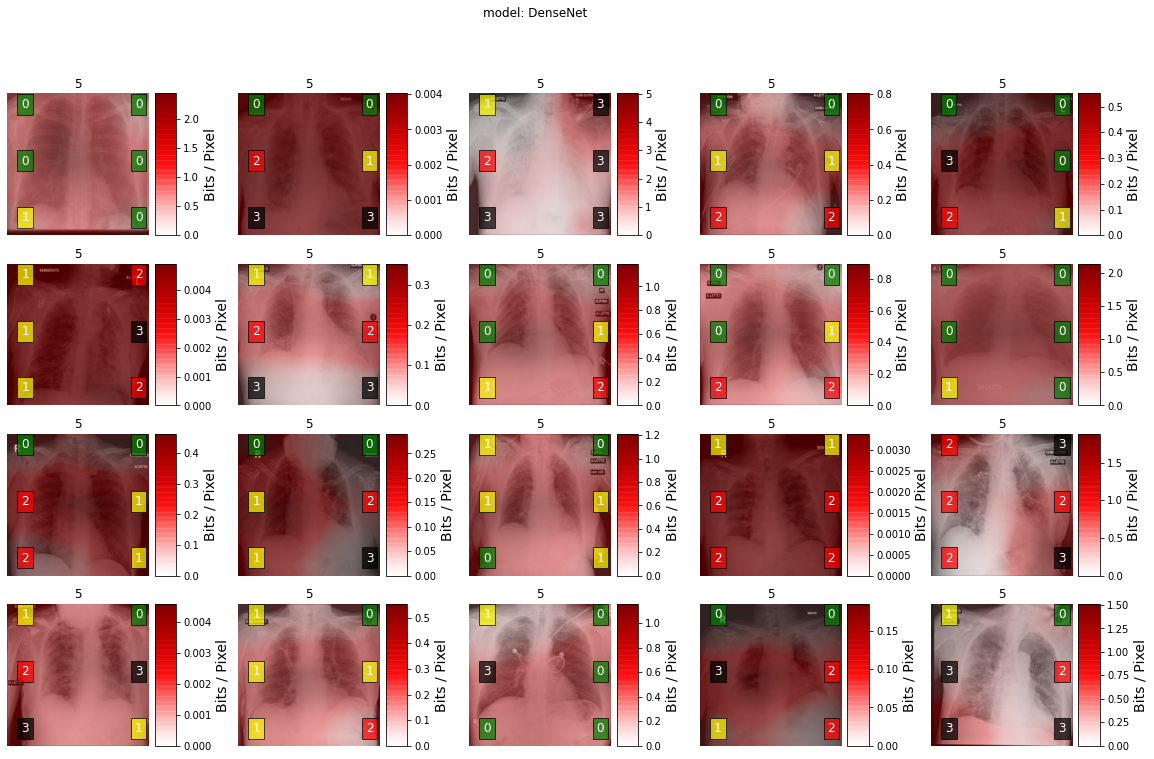

In [ ]:
visualize_heatmap(seed=seed, beta=20, reverse_lambda=True, loss_fn=deviation_loss(original_model=original_model))

## Comparision

In [ ]:
def comparison(seed=None):
  fig, axes = plt.subplots(1, 6, figsize=(24, 6))
  if seed is None:
    seed = np.random.randint(0, 1000000000)
  print("seed is {}".format(seed))
  np.random.seed(seed)
  reverse_lambda = [False, True, False, True, False, True]
  beta = [15, 15, 15, 15, 15, 15]
  # beta = [10, 10, 5, 5, 10, 10]
  sample_idx = np.random.choice(2000)
  img, target, idx = dataset[sample_idx]
  print("global score is {}".format(target))
  img = img[None].to(dev)
  def model_loss_closure_with_target(input):
        loss = torch.nn.MSELoss()
        mse_loss = loss(model(input), torch.tensor(target).float().to(dev))
        return mse_loss
  def model_loss_closure_no_target(input):
        loss = torch.nn.MSELoss()
        mse_loss = -loss(model(input), torch.tensor(0.).to(dev))
        return mse_loss
  # load an original model for score generation
  saved_model = torch.load(MODEL_PATH, map_location=dev)
  original_model = saved_model['model'].module
  del saved_model
  original_model.to(dev).eval()
  def model_loss_closure_deviation(input):
        loss = torch.nn.MSELoss()
        mse_loss = loss(model(input), original_model(input))
        return mse_loss
  loss_function = [model_loss_closure_with_target, model_loss_closure_with_target, model_loss_closure_no_target, model_loss_closure_no_target, model_loss_closure_deviation, model_loss_closure_deviation]
  for i, ax in enumerate(axes.flatten()):
      iba.reverse_lambda = reverse_lambda[i]
      iba.beta = beta[i]
      # execute the model on a given sample and return the target NLL
      model_loss_closure = loss_function[i]
      
      # generate the heatmap
      heatmap = iba.analyze(img, model_loss_closure)
      
      # reverse the data pre-processing for plotting the original image
      np_img = tensor_to_np_img(img[0])
      
      # show the heatmap
      plot_saliency_map(heatmap, np_img,  ax=ax)
      ax.set_title(idx)

      # show label
      scores = local_score_dataset.getScore(idx)
      color_list = ["green", "yellow", "red", "black"]
      for id, score in enumerate(scores):
        row = (1-id%3/2)*0.8 + 0.1
        col = id//3 * 0.8 + 0.1
        plt.text(col, row, score, 
                color="white",
                fontsize = 12,
                bbox=dict(facecolor=color_list[score], alpha=0.7), 
                transform=ax.transAxes)
      
  fig.suptitle("model: {}".format(type(model).__name__))
  local_score_dataset.getScore(idx)
  plt.show()

seed is 802047145
global score is 5.0


/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


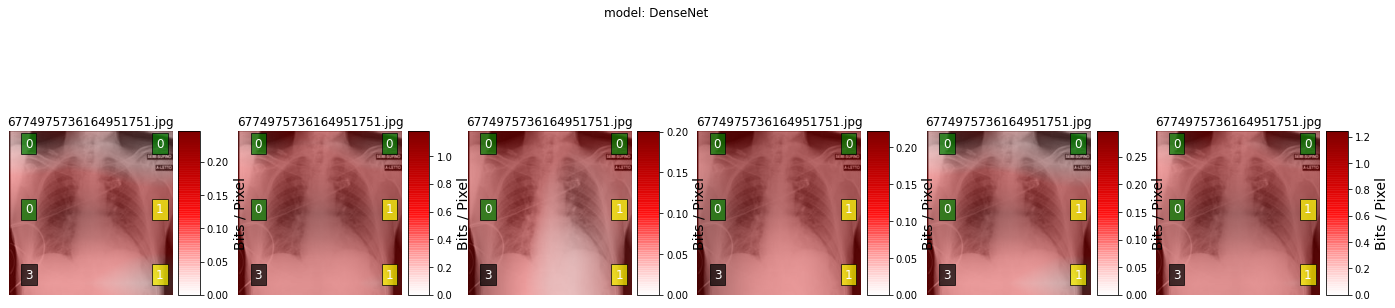

In [ ]:
comparison()

seed is 212979245
global score is 5.0


/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


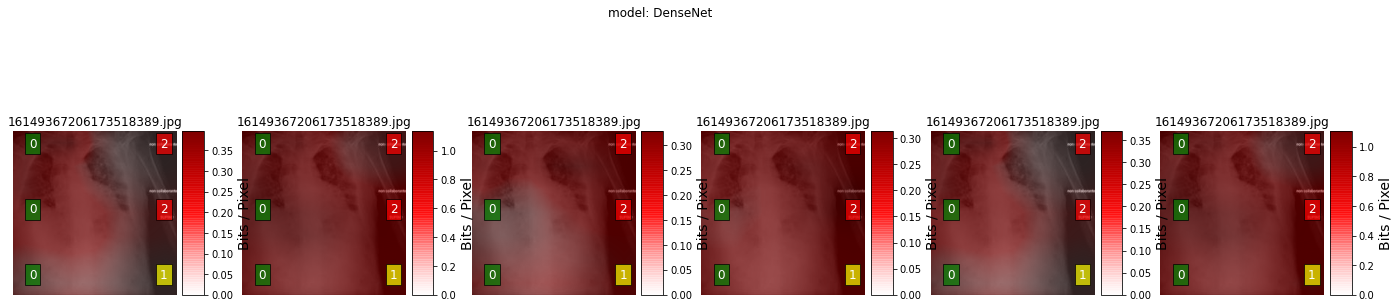

In [ ]:
comparison()

seed is 85187085
global score is 6.0


/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


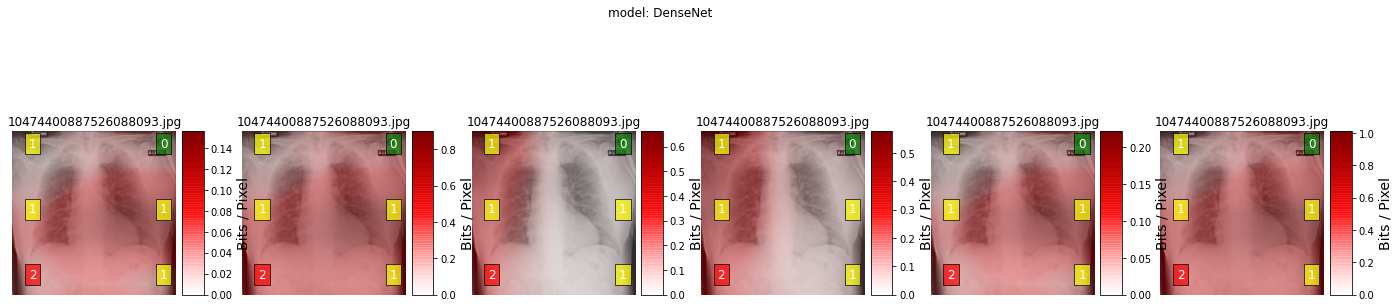

In [ ]:
comparison()

seed is 762057883
global score is 7.0


/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


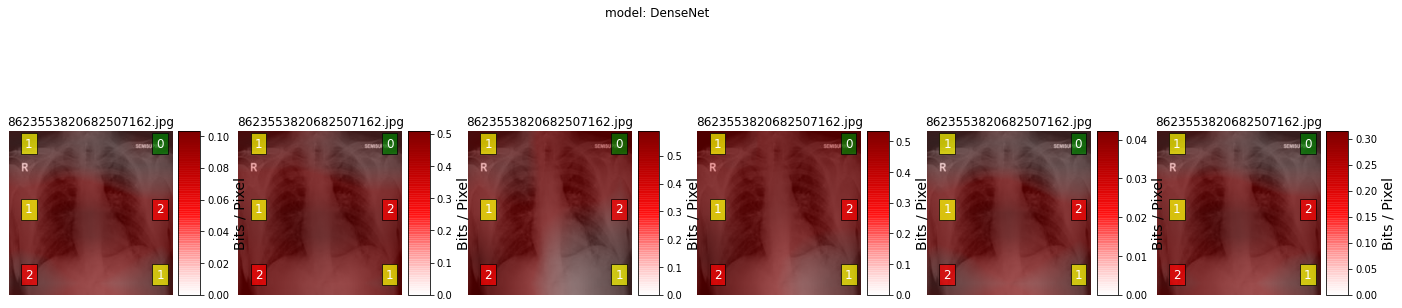

In [ ]:
comparison()

seed is 196253885
global score is 1.0


/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


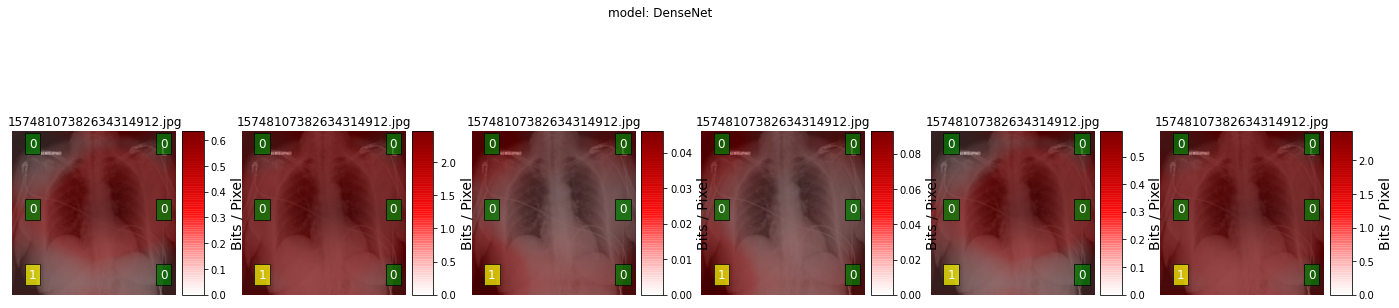

In [ ]:
comparison()

seed is 374281897
global score is 1.0


/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


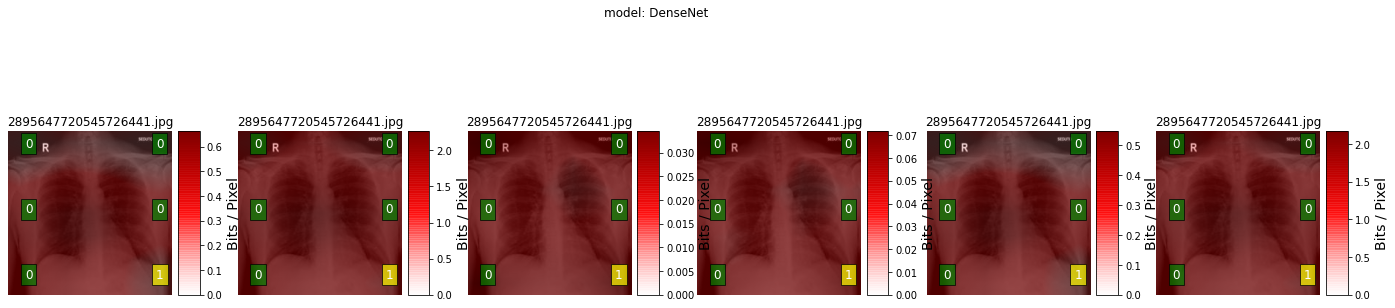

In [ ]:
comparison()

seed is 794733348
global score is 9.0


/content/drive/My Drive/Prak_MLMI/IBA/pytorch.py:577: UserWarning: Selected estimator was only fitted on 32 samples. Might not be enough! We recommend 10.000 samples.
  warnings.warn(f"Selected estimator was only fitted on {self.estimator.n_samples()} "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


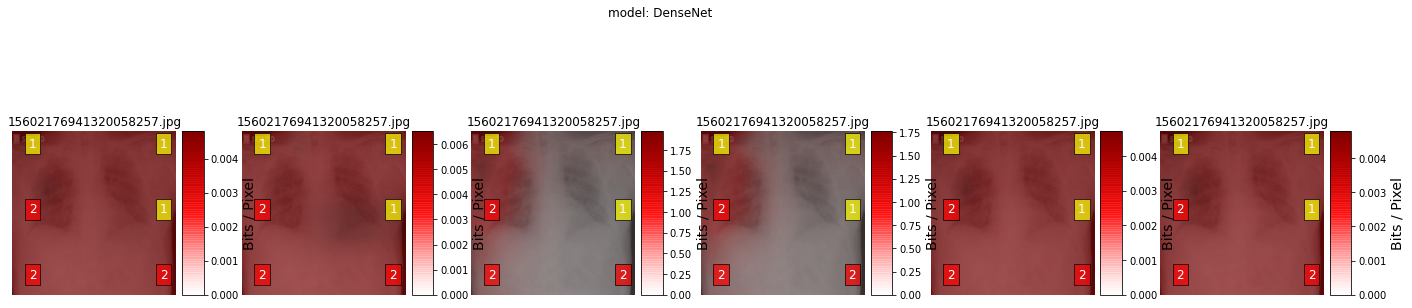

In [ ]:
comparison()

# BrixIA classification model

In [ ]:
imagenet_dir = '/home/yang/MLMI_InfoBottleneck/imagenet'
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
PATH_TO_IMAGES = prak_dir + "/BrixIAsmall"
MODEL_PATH = prak_dir + '/model/results/classification_checkpoint_best'
label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# select a model to analyse
saved_model = torch.load(MODEL_PATH, map_location=dev)
model = saved_model['model'].module
del saved_model
model.to(dev).eval()

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
    'val': Compose([
        Resize(224),
        CenterCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ]),
}

# create dataloader
classification_dataset = CXR.CXRDataset(
    path_to_images=PATH_TO_IMAGES,
    fold='train',
    transform=data_transforms['train'],
    fine_tune=True,
    label_path=label_path)
classification_dataloader = torch.utils.data.DataLoader(
    classification_dataset, 32, shuffle=True, num_workers=4)


In [ ]:
img, label, idx = classification_dataset[5]
print(label)
print(idx)
len(dataset)

[0 1 0 0]
4927439592595712537.jpg


3924

In [ ]:
classification_iba = IBA(model.features.denseblock3)
classification_iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [ ]:
classification_iba.estimate(model, dataloader, device=dev, n_samples=1000, progbar=True)

In [ ]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, classification_iba.estimator.mean()[neuron],  classification_iba.estimator.std()[neuron]))

Neuron at position (12, 3, 4) has mean -0.14 and std 0.06


In [ ]:
classification_iba.estimator.n_samples()

1024

## Display Heatmaps for some random samples



In [ ]:
%matplotlib inline

In [ ]:
# generate seed for comparision consistancy
seed = np.random.randint(0, 1000000000)

In [ ]:
def bce_loss(target):
  def model_loss_closure(input):
    loss = nn.BCEWithLogitsLoss()
    mse_loss = loss((input), torch.tensor(target).view(1,-1).expand(10, -1).to(dev).float())
    return mse_loss
  return model_loss_closure

In [ ]:
def visualize_heatmap(beta=2, reverse_lambda=False, seed=None, loss_fn=None):
  fig, axes = plt.subplots(4, 5, figsize=(20, 12))
  np.random.seed(seed)
  classification_iba.reverse_lambda = False
  classification_iba.beta = 2
  for ax, sample_idx in zip(axes.flatten(), np.random.choice(2000, 20)):
      img, target, idx = classification_dataset[sample_idx]
      img = img[None].to(dev)
      
      # execute the model on a given sample and return the target NLL
      # def model_loss_closure(input):
      #   loss = nn.BCEWithLogitsLoss()
      #   mse_loss = loss(model(input), torch.tensor(target).view(1,-1).expand(10, -1).to(dev).float())
      #   return mse_loss
      model_loss_closure = loss_fn(target)
      
      # generate the heatmap
      heatmap = classification_iba.analyze(img, model_loss_closure)
      
      # reverse the data pre-processing for plotting the original image
      np_img = tensor_to_np_img(img[0])
      
      # show the heatmap
      plot_saliency_map(heatmap, np_img,  ax=ax)
      ax.set_title(idx)
                
      # show label
      scores = local_score_dataset.getScore(idx)
      color_list = ["green", "yellow", "red", "black"]
      for idx, score in enumerate(scores):
        row = (1-idx%3/2)*0.8 + 0.1
        col = idx//3 * 0.8 + 0.1
        plt.text(col, row, score, 
                color="white",
                fontsize = 12,
                bbox=dict(facecolor=color_list[score], alpha=0.7), 
                transform=ax.transAxes)

      # set subplot title
      ax.set_title('{}'.format(idx))
      
  fig.suptitle("model: {}".format(type(model).__name__))
  plt.show()

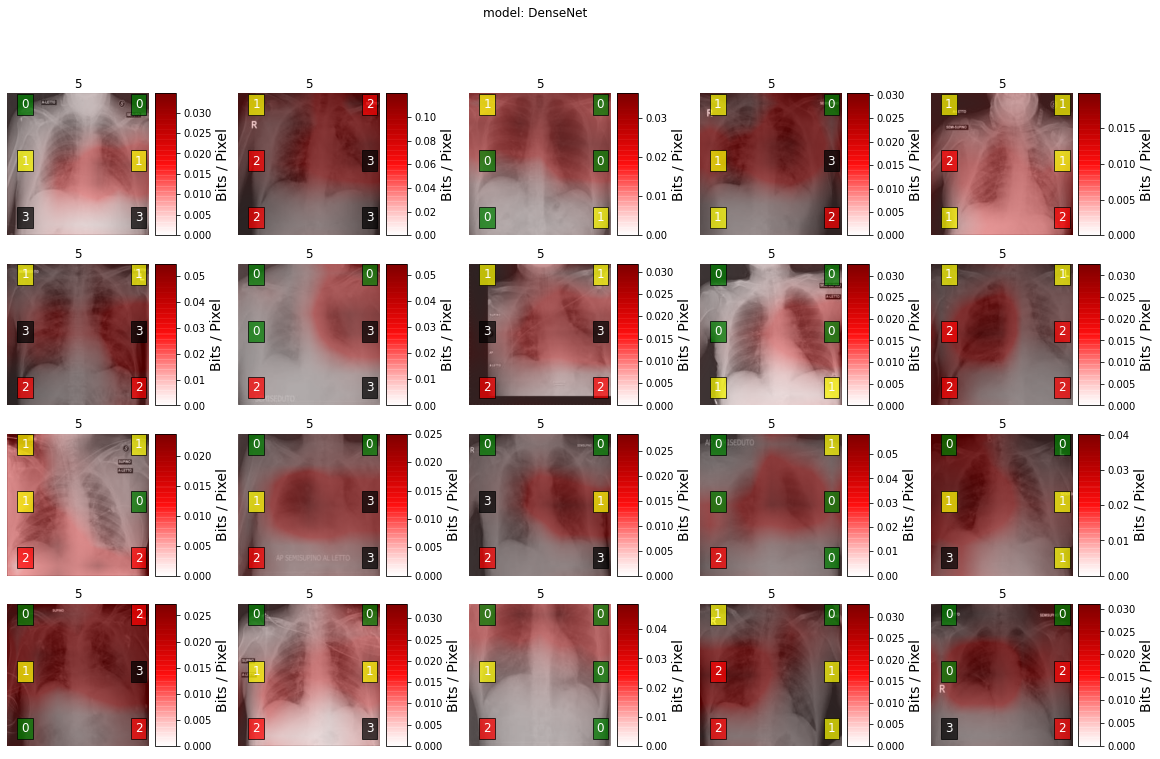

In [ ]:
visualize_heatmap(beta=2, reverse_lambda=False, seed=seed, loss_fn=bce_loss)

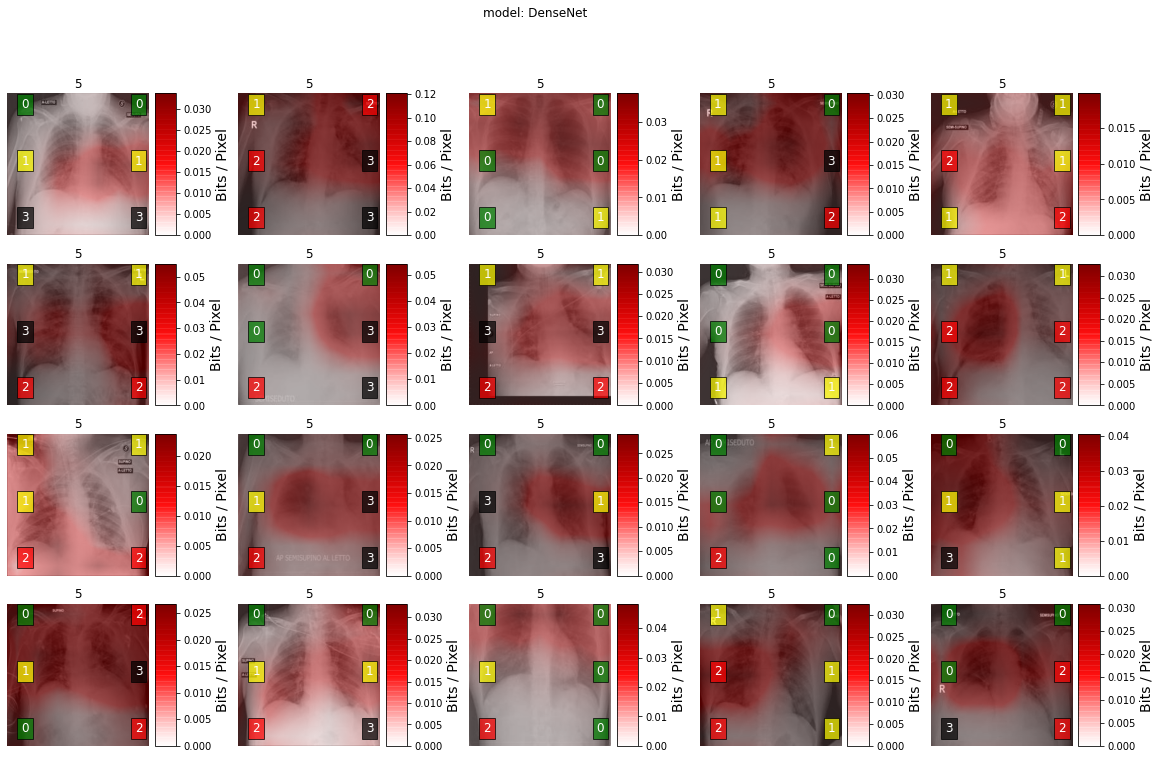

In [ ]:
visualize_heatmap(beta=2, reverse_lambda=True, seed=seed, loss_fn=bce_loss)